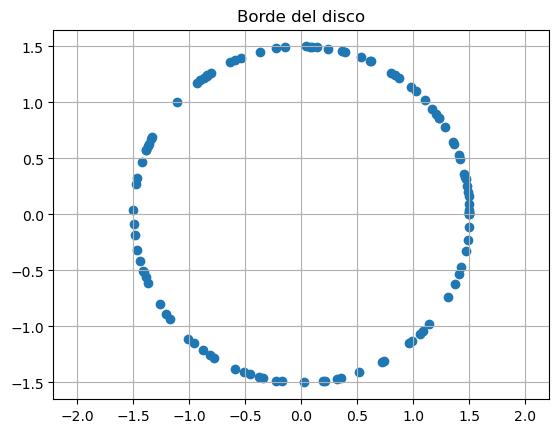

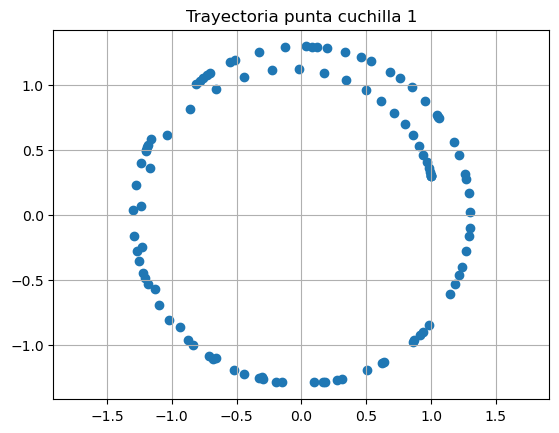

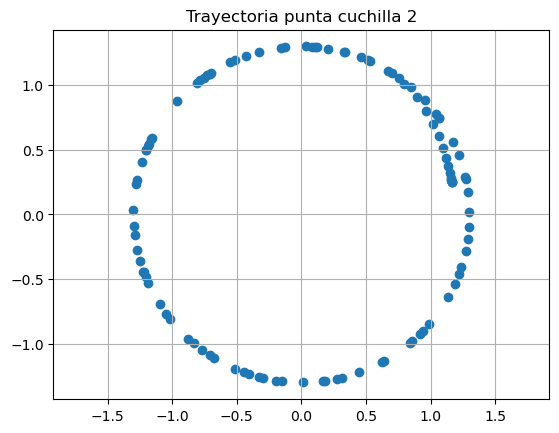

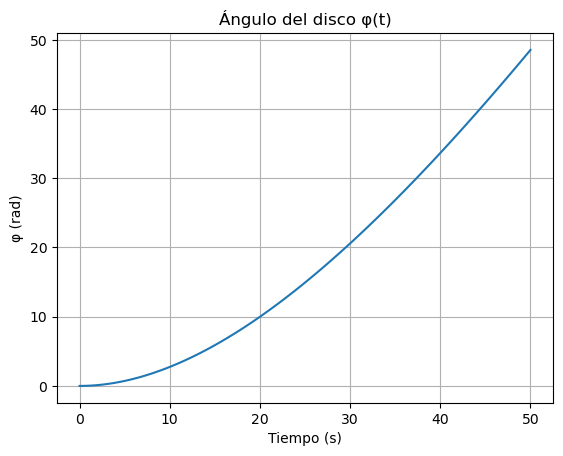

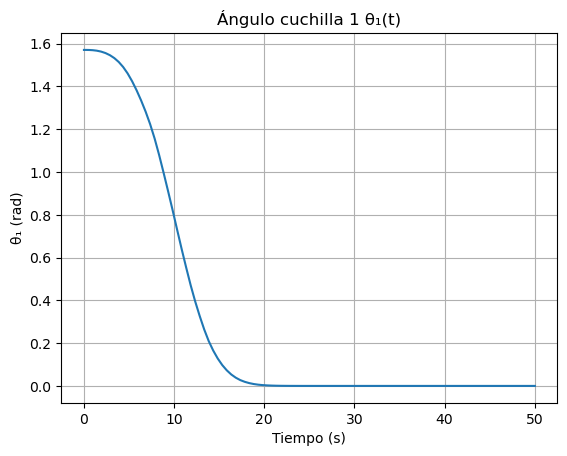

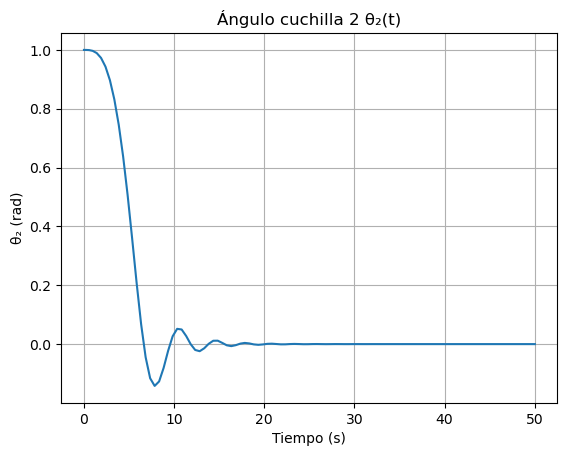

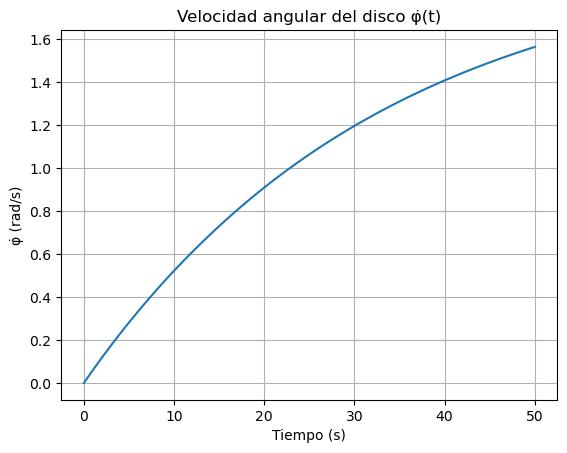

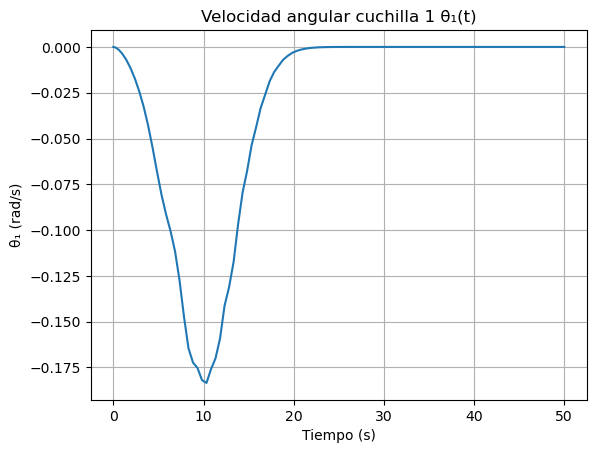

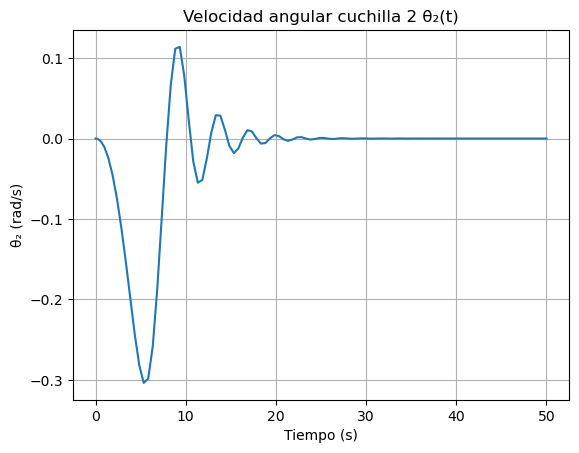

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator

# -- Parámetros del sistema (ajusta según tu modelo) --
M = 20      # masa del disco
m = 5       # masa de cada cuchilla
R = 1.5     # radio del disco
r = 1       # distancia pivote
L = 0.3     # longitud de la cuchilla

# ------------------------
# Coeficientes base
# ------------------------
b1 = 1     # coeficiente base cuchilla 1
b2 = 1       # coeficiente base cuchilla 2
c_disk = 1   # fricción viscosa del disco
c_th1 = 1    # amortiguamiento pivote cuchilla 1
c_th2 = 0.1  # amortiguamiento pivote cuchilla 2
theta01 = np.pi/2  # ángulo inicial cuchilla 1
theta02 = 1        # ángulo inicial cuchilla 2

# Función de torque del motor
def tau_motor(t):
    return 2.0

# Momentos de inercia
I_disc  = 0.5 * M * R**2
I_blade = (1/3) * m * L**2

# ------------------------
# Campo de densidad de pasto
# ------------------------
x_grid = np.linspace(-R, R, 200)
y_grid = np.linspace(-R, R, 200)
X, Y  = np.meshgrid(x_grid, y_grid)
rho   = 1 + 0.5 * np.sin(2 * np.pi * X / R) * np.cos(2 * np.pi * Y / R)
interpolator = RegularGridInterpolator((x_grid, y_grid), rho,
                                       bounds_error=False, fill_value=1.0)

def b_field(x_tip, y_tip, base_b):
    return base_b * interpolator((x_tip, y_tip))

# ------------------------
# Definición de torques
# ------------------------
def tau_disc_b(phi_dot, theta, theta_dot, b):
    term_phi  = b * phi_dot   * np.sin(theta) * (r*L**2/2 + (L**3/3)*np.cos(theta))
    term_th   = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_phi + term_th


def tau_blade_b(phi_dot, theta, theta_dot, b):
    term_cut  = b * phi_dot   * np.sin(theta) * (r*L**2/2)
    term_drag = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_cut + term_drag


def theta_dd(phi_dot, theta, theta_dot, b, c_th):
    cent1 = 0.5 * m * r * L * phi_dot**2 * np.sin(theta)
    cent2 = (1/3) * m * L**2 * phi_dot**2 * np.sin(theta) * np.cos(theta)
    tau_g = tau_blade_b(phi_dot, theta, theta_dot, b)
    tau_d = -c_th * theta_dot
    return (-cent1 - cent2 - tau_g + tau_d) / I_blade

# ------------------------
# Sistema de ecuaciones
# ------------------------
def odes(t, y):
    phi, phidot, th1, dth1, th2, dth2 = y
    I_tot = I_disc + 2*(m*r**2 + I_blade)

    # Posiciones pivote y puntas
    x_piv = r * np.cos(phi)
    y_piv = r * np.sin(phi)
    x_tip1 = x_piv + L * np.cos(phi + th1)
    y_tip1 = y_piv + L * np.sin(phi + th1)
    x_tip2 = x_piv + L * np.cos(phi + th2)
    y_tip2 = y_piv + L * np.sin(phi + th2)

    # Coeficientes locales
    b1_loc = b_field(x_tip1, y_tip1, b1)
    b2_loc = b_field(x_tip2, y_tip2, b2)

    # Torques de pasto sobre el disco
    t1 = tau_disc_b(phidot, th1, dth1, b1_loc)
    t2 = tau_disc_b(phidot, th2, dth2, b2_loc)

    # Ecuación del disco
    phidd = (tau_motor(t) - t1 - t2 - c_disk*phidot) / I_tot

    # Aceleraciones de las cuchillas
    dth1dd = theta_dd(phidot, th1, dth1, b1_loc, c_th1)
    dth2dd = theta_dd(phidot, th2, dth2, b2_loc, c_th2)

    return [phidot, phidd, dth1, dth1dd, dth2, dth2dd]

# ------------------------
# Condiciones iniciales y resolución
# ------------------------
y0 = [0, 0, theta01, 0, theta02, 0]
t_span = (0, 50)
sol = solve_ivp(odes, t_span, y0, method='RK45',
                rtol=1e-2, atol=1e-5, max_step=0.5)

# ------------------------
# Extracción de resultados
# ------------------------
t = sol.t
phi      = sol.y[0]
phi_dot  = sol.y[1]
theta1   = sol.y[2]
dth1     = sol.y[3]
theta2   = sol.y[4]
dth2     = sol.y[5]

# Coordenadas disco y puntas
x_disk = R * np.cos(phi)
y_disk = R * np.sin(phi)
x_piv  = r * np.cos(phi)
y_piv  = r * np.sin(phi)
x_tip1 = x_piv + L * np.cos(phi + theta1)
y_tip1 = y_piv + L * np.sin(phi + theta1)
x_tip2 = x_piv + L * np.cos(phi + theta2)
y_tip2 = y_piv + L * np.sin(phi + theta2)

# ------------------------
# Gráficas de posición
# ------------------------
plt.figure()
plt.scatter(x_disk, y_disk)
plt.title('Borde del disco')
plt.axis('equal')
plt.grid(True)

plt.figure()
plt.scatter(x_tip1, y_tip1)
plt.title('Trayectoria punta cuchilla 1')
plt.axis('equal')
plt.grid(True)

plt.figure()
plt.scatter(x_tip2, y_tip2)
plt.title('Trayectoria punta cuchilla 2')
plt.axis('equal')
plt.grid(True)

# ------------------------
# Gráficas de ángulos
# ------------------------
plt.figure()
plt.plot(t, phi)
plt.xlabel('Tiempo (s)')
plt.ylabel('φ (rad)')
plt.title('Ángulo del disco φ(t)')
plt.grid(True)

plt.figure()
plt.plot(t, theta1)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ₁ (rad)')
plt.title('Ángulo cuchilla 1 θ₁(t)')
plt.grid(True)

plt.figure()
plt.plot(t, theta2)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ₂ (rad)')
plt.title('Ángulo cuchilla 2 θ₂(t)')
plt.grid(True)

# ------------------------
# Gráficas de velocidades angulares
# ------------------------
plt.figure()
plt.plot(t, phi_dot)
plt.xlabel('Tiempo (s)')
plt.ylabel('φ̇ (rad/s)')
plt.title('Velocidad angular del disco φ̇(t)')
plt.grid(True)

plt.figure()
plt.plot(t, dth1)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ̇₁ (rad/s)')
plt.title('Velocidad angular cuchilla 1 θ̇₁(t)')
plt.grid(True)

plt.figure()
plt.plot(t, dth2)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ̇₂ (rad/s)')
plt.title('Velocidad angular cuchilla 2 θ̇₂(t)')
plt.grid(True)

plt.show()

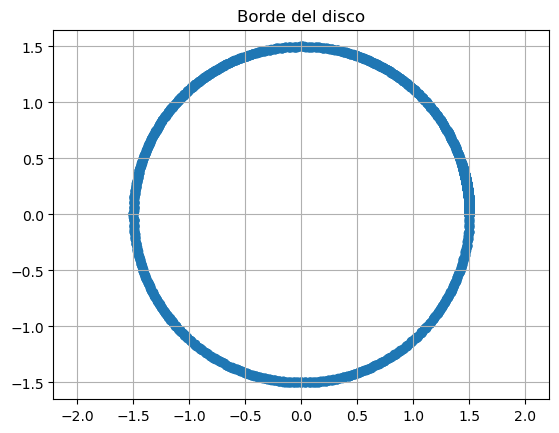

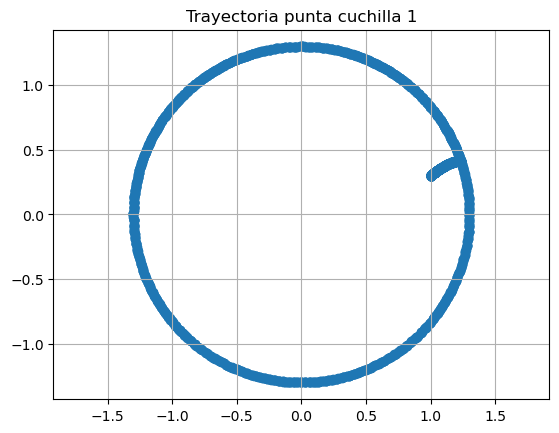

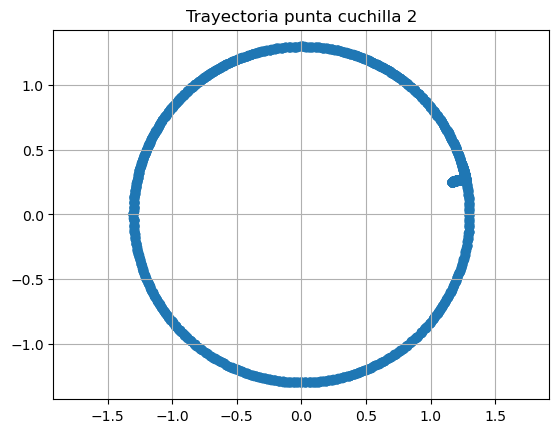

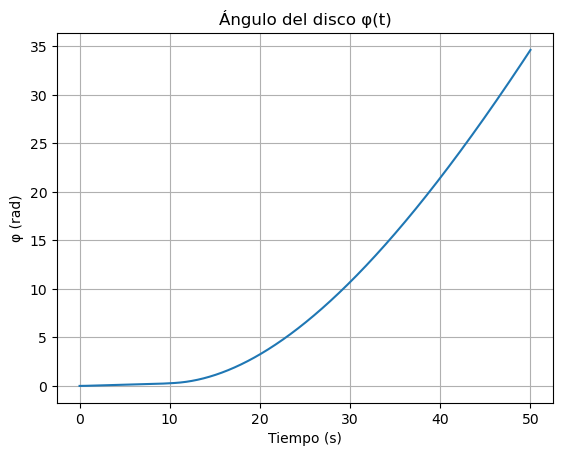

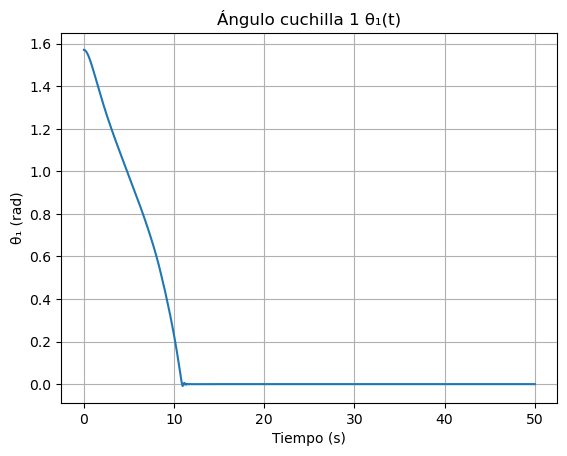

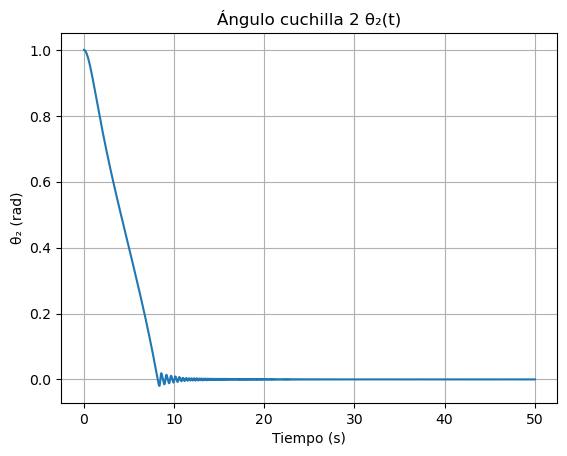

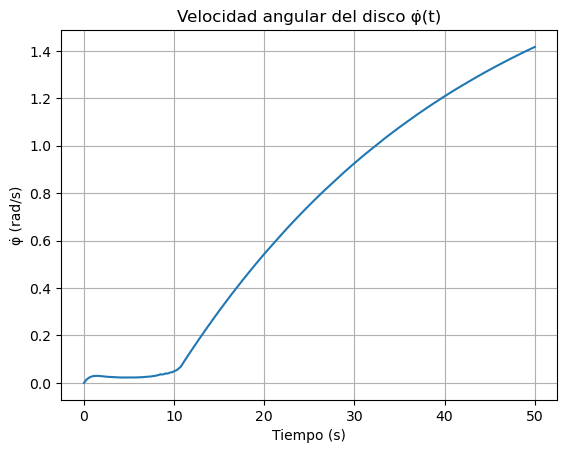

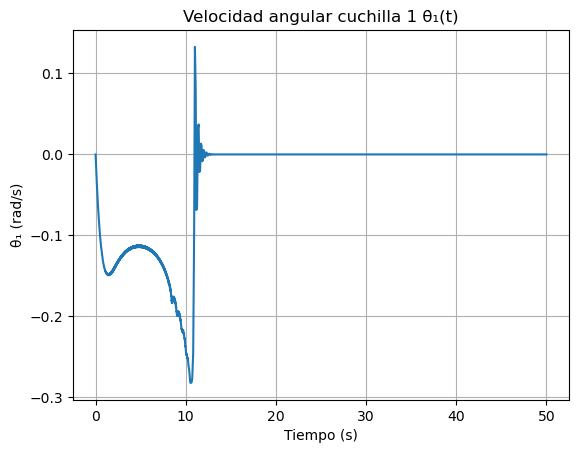

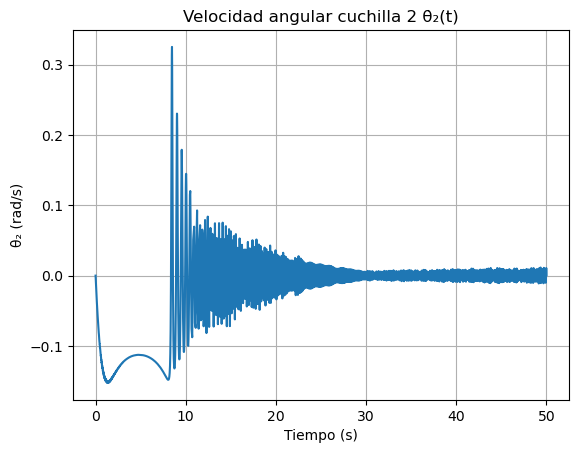

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator

# -- Parámetros del sistema (ajusta según tu modelo) --
M = 20      # masa del disco
m = 5       # masa de cada cuchilla
R = 1.5     # radio del disco
r = 1       # distancia pivote
L = 0.3     # longitud de la cuchilla

# ------------------------
# Coeficientes base
# ------------------------
b1 = 10000    # coeficiente base cuchilla 1
b2 = 10000       # coeficiente base cuchilla 2
c_disk = 1   # fricción viscosa del disco
c_th1 = 1    # amortiguamiento pivote cuchilla 1
c_th2 = 0.1  # amortiguamiento pivote cuchilla 2
theta01 = np.pi/2  # ángulo inicial cuchilla 1
theta02 = 1        # ángulo inicial cuchilla 2

# Función de torque del motor
def tau_motor(t):
    return 2.0

# Momentos de inercia
I_disc  = 0.5 * M * R**2
I_blade = (1/3) * m * L**2

# ------------------------
# Campo de densidad de pasto
# ------------------------
x_grid = np.linspace(-R, R, 200)
y_grid = np.linspace(-R, R, 200)
X, Y  = np.meshgrid(x_grid, y_grid)
rho   = 1 + 0.5 * np.sin(2 * np.pi * X / R) * np.cos(2 * np.pi * Y / R)
interpolator = RegularGridInterpolator((x_grid, y_grid), rho,
                                       bounds_error=False, fill_value=1.0)

def b_field(x_tip, y_tip, base_b):
    return base_b * interpolator((x_tip, y_tip))

# ------------------------
# Definición de torques
# ------------------------
def tau_disc_b(phi_dot, theta, theta_dot, b):
    term_phi  = b * phi_dot   * np.sin(theta) * (r*L**2/2 + (L**3/3)*np.cos(theta))
    term_th   = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_phi + term_th


def tau_blade_b(phi_dot, theta, theta_dot, b):
    term_cut  = b * phi_dot   * np.sin(theta) * (r*L**2/2)
    term_drag = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_cut + term_drag


def theta_dd(phi_dot, theta, theta_dot, b, c_th):
    cent1 = 0.5 * m * r * L * phi_dot**2 * np.sin(theta)
    cent2 = (1/3) * m * L**2 * phi_dot**2 * np.sin(theta) * np.cos(theta)
    tau_g = tau_blade_b(phi_dot, theta, theta_dot, b)
    tau_d = -c_th * theta_dot
    return (-cent1 - cent2 - tau_g + tau_d) / I_blade

# ------------------------
# Sistema de ecuaciones
# ------------------------
def odes(t, y):
    phi, phidot, th1, dth1, th2, dth2 = y
    I_tot = I_disc + 2*(m*r**2 + I_blade)

    # Posiciones pivote y puntas
    x_piv = r * np.cos(phi)
    y_piv = r * np.sin(phi)
    x_tip1 = x_piv + L * np.cos(phi + th1)
    y_tip1 = y_piv + L * np.sin(phi + th1)
    x_tip2 = x_piv + L * np.cos(phi + th2)
    y_tip2 = y_piv + L * np.sin(phi + th2)

    # Coeficientes locales
    b1_loc = b_field(x_tip1, y_tip1, b1)
    b2_loc = b_field(x_tip2, y_tip2, b2)

    # Torques de pasto sobre el disco
    t1 = tau_disc_b(phidot, th1, dth1, b1_loc)
    t2 = tau_disc_b(phidot, th2, dth2, b2_loc)

    # Ecuación del disco
    phidd = (tau_motor(t) - t1 - t2 - c_disk*phidot) / I_tot

    # Aceleraciones de las cuchillas
    dth1dd = theta_dd(phidot, th1, dth1, b1_loc, c_th1)
    dth2dd = theta_dd(phidot, th2, dth2, b2_loc, c_th2)

    return [phidot, phidd, dth1, dth1dd, dth2, dth2dd]

# ------------------------
# Condiciones iniciales y resolución
# ------------------------
y0 = [0, 0, theta01, 0, theta02, 0]
t_span = (0, 50)
sol = solve_ivp(odes, t_span, y0, method='RK45',
                rtol=1e-2, atol=1e-5, max_step=0.5)

# ------------------------
# Extracción de resultados
# ------------------------
t = sol.t
phi      = sol.y[0]
phi_dot  = sol.y[1]
theta1   = sol.y[2]
dth1     = sol.y[3]
theta2   = sol.y[4]
dth2     = sol.y[5]

# Coordenadas disco y puntas
x_disk = R * np.cos(phi)
y_disk = R * np.sin(phi)
x_piv  = r * np.cos(phi)
y_piv  = r * np.sin(phi)
x_tip1 = x_piv + L * np.cos(phi + theta1)
y_tip1 = y_piv + L * np.sin(phi + theta1)
x_tip2 = x_piv + L * np.cos(phi + theta2)
y_tip2 = y_piv + L * np.sin(phi + theta2)

# ------------------------
# Gráficas de posición
# ------------------------
plt.figure()
plt.scatter(x_disk, y_disk)
plt.title('Borde del disco')
plt.axis('equal')
plt.grid(True)

plt.figure()
plt.scatter(x_tip1, y_tip1)
plt.title('Trayectoria punta cuchilla 1')
plt.axis('equal')
plt.grid(True)

plt.figure()
plt.scatter(x_tip2, y_tip2)
plt.title('Trayectoria punta cuchilla 2')
plt.axis('equal')
plt.grid(True)

# ------------------------
# Gráficas de ángulos
# ------------------------
plt.figure()
plt.plot(t, phi)
plt.xlabel('Tiempo (s)')
plt.ylabel('φ (rad)')
plt.title('Ángulo del disco φ(t)')
plt.grid(True)

plt.figure()
plt.plot(t, theta1)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ₁ (rad)')
plt.title('Ángulo cuchilla 1 θ₁(t)')
plt.grid(True)

plt.figure()
plt.plot(t, theta2)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ₂ (rad)')
plt.title('Ángulo cuchilla 2 θ₂(t)')
plt.grid(True)

# ------------------------
# Gráficas de velocidades angulares
# ------------------------
plt.figure()
plt.plot(t, phi_dot)
plt.xlabel('Tiempo (s)')
plt.ylabel('φ̇ (rad/s)')
plt.title('Velocidad angular del disco φ̇(t)')
plt.grid(True)

plt.figure()
plt.plot(t, dth1)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ̇₁ (rad/s)')
plt.title('Velocidad angular cuchilla 1 θ̇₁(t)')
plt.grid(True)

plt.figure()
plt.plot(t, dth2)
plt.xlabel('Tiempo (s)')
plt.ylabel('θ̇₂ (rad/s)')
plt.title('Velocidad angular cuchilla 2 θ̇₂(t)')
plt.grid(True)

plt.show()

tor que vs angular
| Variable                 | Significado                              | Unidades esperadas (SI) |
| ------------------------ | ---------------------------------------- | ----------------------- |
| `M`, `m`                 | Masa del disco y cuchillas               | **kg** (kilogramos)     |
| `R`, `r`, `L`            | Radios y longitudes                      | **m** (metros)          |
| `phi`, `theta`           | Ángulos                                  | **rad** (radianes)      |
| `phidot`, `dth1`, `dth2` | Velocidades angulares                    | **rad/s**               |
| `tau_motor`              | Torque aplicado                          | **N·m** (newton·metro)  |
| `c_disk`, `c_th`         | Coeficientes de fricción viscosa         | **N·m·s/rad**           |
| `b1`, `b2`               | Coeficientes de interacción con el pasto | **(N·m·s)/rad²** aprox. |
| `t`                      | Tiempo                                   | **s** (segundos)        |


In [6]:
import os
# … al inicio de tu script …
out_dir = "Proyecto/Propuesta solución/Final"
os.makedirs(out_dir, exist_ok=True)

# (1) Recalcula x_tip, y_tip para cada instante (arrays de longitud N)
x_piv   = r * np.cos(phi)
y_piv   = r * np.sin(phi)
x_tip1  = x_piv + L * np.cos(phi + theta1)
y_tip1  = y_piv + L * np.sin(phi + theta1)
x_tip2  = x_piv + L * np.cos(phi + theta2)
y_tip2  = y_piv + L * np.sin(phi + theta2)

# (2) Coeficientes locales (arrays)
b1_loc  = b_field(x_tip1, y_tip1, b1)
b2_loc  = b_field(x_tip2, y_tip2, b2)

# (3) Torques por el pasto (arrays)
t1_arr  = tau_disc_b(phi_dot, theta1, dth1, b1_loc)
t2_arr  = tau_disc_b(phi_dot, theta2, dth2, b2_loc)

# (4) Torque neto en cada instante (array)
tau_net = tau_motor(t) - t1_arr - t2_arr - c_disk * phi_dot






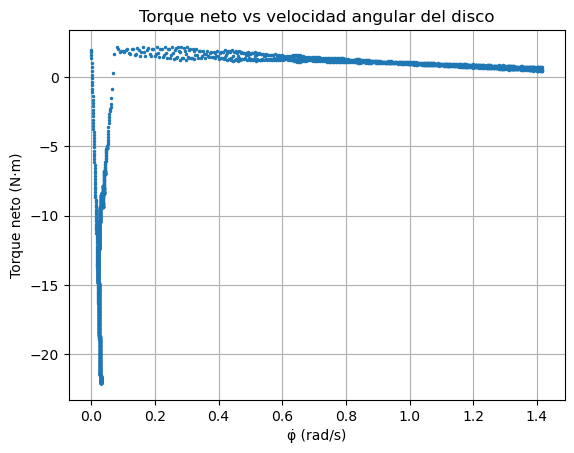

In [7]:
# ------------------------
# Gráficas
# ------------------------
# (5) Dibuja
plt.figure()
plt.plot(phi_dot, tau_net, '.', markersize=3)
plt.xlabel('φ̇ (rad/s)')
plt.ylabel('Torque neto (N·m)')
plt.title('Torque neto vs velocidad angular del disco')
plt.grid(True)
plt.show()

fname = os.path.join(out_dir, "torque_vs_velocidad.png")
plt.savefig(fname, dpi=300)  
plt.close()




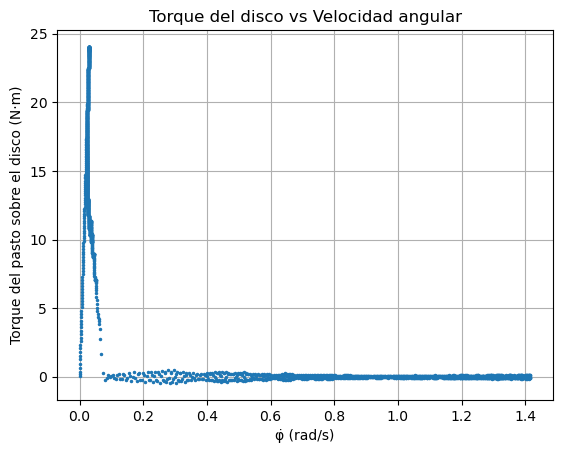

In [ ]:
# ------------------------
t1_arr = tau_disc_b(phi_dot, theta1, dth1, b1_loc)
t2_arr = tau_disc_b(phi_dot, theta2, dth2, b2_loc)
tau_pasto = t1_arr + t2_arr   

# ------------------------
plt.figure()
plt.plot(phi_dot, tau_pasto, '.', markersize=3)
plt.xlabel('φ̇ (rad/s)')
plt.ylabel('Torque del pasto sobre el disco (N·m)')
plt.title('Torque del disco vs Velocidad angular')
plt.grid(True)
plt.show()

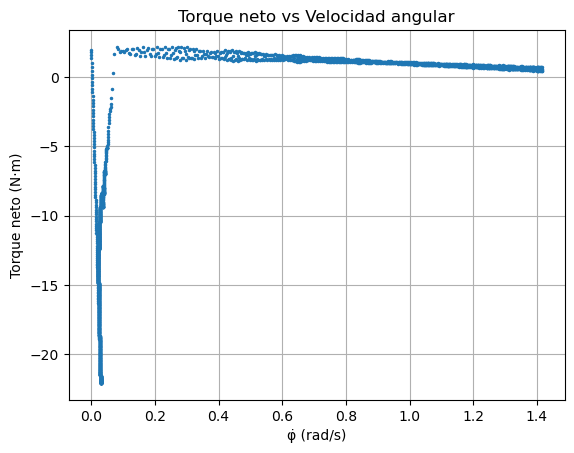

In [9]:
# 3) Torque de pasto sobre el disco (vectorizado)
tau_net = tau_motor(t) - tau_pasto - c_disk*phi_dot

# 4) Gráfica Torque del disco vs Velocidad angular
plt.figure()
plt.plot(phi_dot, tau_net, '.', markersize=3)
plt.ylabel('Torque neto (N·m)')
plt.title('Torque neto vs Velocidad angular')
plt.xlabel('φ̇ (rad/s)')
plt.grid(True)
plt.show()